In [1]:
using DrWatson
@quickactivate "MEngProject"
using MEngProject, CUDA, DifferentialEquations, PyPlot, NNlib,  ImageFiltering, Images, MEngProject, MEngProject.LamKernels, MEngProject.Laminart, MEngProject.Utils, BenchmarkTools, Test

┌ Info: Precompiling MEngProject [d0493a11-efc0-4c7c-9b66-d0bd5a04cc55]
└ @ Base loading.jl:1260


In [2]:
function reshape2d_4d(img::AbstractArray)
    reshape(img, size(img)[1], size(img)[2], 1, 1)
end

reshape2d_4d (generic function with 1 method)

In [3]:
img = convert(Array{Float32,2}, load(datadir("Iine_100_100_gs.png")));
img = reshape2d_4d(img)
img = cu(img)
r = similar(img)

p = LaminartGPU.kernels(img, Parameters.parameters);

LaminartGPU.I_u!(r, img, p)
temp_out = (I = img, r = r)
p = merge(p, temp_out);

In [4]:
tspan = (0.0f0, 5f0)
u0 = cu(reshape(zeros(Float32, p.dim_i, p.dim_j*(5*p.K+2)), p.dim_i, p.dim_j, 5*p.K+2,1));

In [5]:
x_lgn = cu(reshape(zeros(Float32, p.dim_i, p.dim_j), p.dim_i, p.dim_j, 1,1))
C = cu(reshape(zeros(Float32, p.dim_i, p.dim_j * p.K), p.dim_i, p.dim_j, p.K,1))
H_z = cu(reshape(zeros(Float32, p.dim_i, p.dim_j * p.K), p.dim_i, p.dim_j, p.K,1));
V_temp_1 = cu(reshape(zeros(Float32, p.dim_i, p.dim_j), p.dim_i, p.dim_j, 1,1));
V_temp_2 = cu(reshape(zeros(Float32, p.dim_i, p.dim_j), p.dim_i, p.dim_j, 1,1));
A_temp = cu(reshape(zeros(Float32, p.dim_i, p.dim_j * p.K), p.dim_i, p.dim_j, p.K,1));
B_temp = cu(reshape(zeros(Float32, p.dim_i, p.dim_j * p.K), p.dim_i, p.dim_j, p.K,1));

In [6]:
arr1 = u0[:, :, 1:p.K,:]
arr2 = u0[:, :, 1:1,:];

In [7]:
f = LaminartGPU.MyFunction(
    similar(arr1),
    similar(arr1),
    similar(arr1),
    similar(arr1),
    similar(arr1),
    similar(arr2),
    similar(arr2),
    similar(arr1),
    similar(arr1),
    similar(arr1),
    similar(arr1),
    similar(arr1),
    similar(arr2),
    similar(arr2),
    x_lgn, C, H_z, V_temp_1, V_temp_2, A_temp, B_temp);

In [76]:
fa = LaminartGPU.MyFunctionnnn(
    similar(arr1),
    similar(arr1),
    similar(arr1),
    similar(arr1),
    similar(arr1),
    similar(arr2),
    similar(arr2),
    similar(arr1),
    similar(arr1),
    similar(arr1),
    similar(arr1),
    similar(arr1),
    similar(arr2),
    similar(arr2),
    x_lgn, C, H_z, V_temp_1, V_temp_2, A_temp, B_temp);

In [196]:
prob= ODEProblem(f, u0, tspan, p);

In [81]:
prob1= ODEProblem(fa, u0, tspan, p);

In [18]:
sol = solve(prob)

retcode: Success
Interpolation: specialized 4th order "free" interpolation
t: 905-element Array{Float32,1}:
 0.0
 1.0f-6
 6.4444416f-6
 2.4450192f-5
 6.62239f-5
 0.00014112459
 0.00025240338
 0.00040083917
 0.00059357367
 0.000836073
 0.00113282
 0.001486989
 0.0019003447
 ⋮
 4.732325
 4.756958
 4.781688
 4.8065157
 4.8314404
 4.8564625
 4.881582
 4.906798
 4.932111
 4.9575205
 4.9830265
 5.0
u: 905-element Array{CuArray{Float32,4,Nothing},1}:
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

...

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0

In [197]:
sol = solve(prob)

retcode: Success
Interpolation: specialized 4th order "free" interpolation
t: 905-element Array{Float32,1}:
 0.0
 1.0f-6
 6.4444416f-6
 2.4450192f-5
 6.62239f-5
 0.00014112459
 0.00025240338
 0.00040083917
 0.00059357367
 0.000836073
 0.00113282
 0.001486989
 0.0019003447
 ⋮
 4.732325
 4.756958
 4.781688
 4.8065157
 4.8314404
 4.8564625
 4.881582
 4.906798
 4.932111
 4.9575205
 4.9830265
 5.0
u: 905-element Array{CuArray{Float32,4,Nothing},1}:
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

...

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0

In [ ]:
@benchmark sol = solve(prob)

changed to ff.x=x_ etc from ff.x= CuArray(x_) in MyFunction

In [198]:
@benchmark sol = solve(prob)

BenchmarkTools.Trial: 
  memory estimate:  1.82 GiB
  allocs estimate:  41566596
  --------------
  minimum time:     36.681 s (2.04% GC)
  median time:      36.681 s (2.04% GC)
  mean time:        36.681 s (2.04% GC)
  maximum time:     36.681 s (2.04% GC)
  --------------
  samples:          1
  evals/sample:     1

In [199]:
@benchmark sol = solve(prob, save_on=false)

BenchmarkTools.Trial: 
  memory estimate:  1.81 GiB
  allocs estimate:  41514217
  --------------
  minimum time:     34.729 s (2.05% GC)
  median time:      34.729 s (2.05% GC)
  mean time:        34.729 s (2.05% GC)
  maximum time:     34.729 s (2.05% GC)
  --------------
  samples:          1
  evals/sample:     1

In [200]:
@benchmark sol = solve(prob, save_on=false, alias_u0=true)

InterruptException: InterruptException:

In [201]:
@benchmark sol = solve(prob, save_on=false, save_start=false)


Stacktrace:
 [1] getproperty at ./Base.jl:26 [inlined]
 [2] macro expansion at /mnt/storage_1/users/cullinanen/.julia/packages/TimerOutputs/dVnaw/src/TimerOutput.jl:206 [inlined]
 [3] macro expansion at /mnt/storage_1/users/cullinanen/.julia/packages/CUDA/h38pe/src/memory.jl:274 [inlined]
 [4] macro expansion at ./util.jl:234 [inlined]
 [5] free at /mnt/storage_1/users/cullinanen/.julia/packages/CUDA/h38pe/src/memory.jl:273 [inlined]
 [6] _unsafe_free!(::CuArray{Float32,4,Nothing}) at /mnt/storage_1/users/cullinanen/.julia/packages/CUDA/h38pe/src/array.jl:53
 [7] unsafe_free!(::CuArray{Float32,4,Nothing}) at /mnt/storage_1/users/cullinanen/.julia/packages/CUDA/h38pe/src/array.jl:42
 [8] ntuple at ./ntuple.jl:43 [inlined]
 [9] copy(::Base.Broadcast.Broadcasted{Base.Broadcast.Style{Tuple},Nothing,typeof(Core.Typeof),Tuple{Tuple{CUDA.CuKernelContext,CuDeviceArray{Float32,4,CUDA.AS.Global},Base.Broadcast.Broadcasted{Nothing,NTuple{4,Base.OneTo{Int64}},typeof(*),Tuple{Base.Broadcast.Broadc

InterruptException()


BenchmarkTools.Trial: 
  memory estimate:  4.44 GiB
  allocs estimate:  102087800
  --------------
  minimum time:     88.512 s (1.59% GC)
  median time:      88.512 s (1.59% GC)
  mean time:        88.512 s (1.59% GC)
  maximum time:     88.512 s (1.59% GC)
  --------------
  samples:          1
  evals/sample:     1

In [8]:
f_nm = LaminartGPU.MyFunction_nm(
    similar(arr1),
    similar(arr1),
    similar(arr1),
    similar(arr1),
    similar(arr1),
    similar(arr2),
    similar(arr2),
    similar(arr1),
    similar(arr1),
    similar(arr1),
    similar(arr1),
    similar(arr1),
    similar(arr2),
    similar(arr2),
    x_lgn, C, H_z, V_temp_1, V_temp_2, A_temp, B_temp);

In [9]:
prob_nm= ODEProblem(f_nm, u0, tspan, p);

In [10]:
@benchmark sol_nm = solve(prob_nm)

InterruptException: InterruptException:

In [12]:
f_nm.x

100×100×2×1 CuArray{Float32,4,Nothing}:
[:, :, 1, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0

In [18]:
@time f_nm.x .= u0[:, :, 1:p.K,:]

  0.001022 seconds (160 allocations: 5.188 KiB)


100×100×2×1 CuArray{Float32,4,Nothing}:
[:, :, 1, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0

In [19]:
@time f.x .= u0[:, :, 1:p.K,:]

  0.000491 seconds (174 allocations: 5.516 KiB)


100×100×2×1 CuArray{Float32,4,Nothing}:
[:, :, 1, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0

In [57]:
@benchmark sol = solve(prob1)

BenchmarkTools.Trial: 
  memory estimate:  6.65 GiB
  allocs estimate:  43379634
  --------------
  minimum time:     38.525 s (2.30% GC)
  median time:      38.525 s (2.30% GC)
  mean time:        38.525 s (2.30% GC)
  maximum time:     38.525 s (2.30% GC)
  --------------
  samples:          1
  evals/sample:     1

ArgumentError: ArgumentError: reducing over an empty collection is not allowed

In [83]:
@benchmark sol = solve(prob1, save_on=false)

BenchmarkTools.Trial: 
  memory estimate:  6.65 GiB
  allocs estimate:  43307302
  --------------
  minimum time:     38.748 s (2.33% GC)
  median time:      38.748 s (2.33% GC)
  mean time:        38.748 s (2.33% GC)
  maximum time:     38.748 s (2.33% GC)
  --------------
  samples:          1
  evals/sample:     1

In [208]:
CUDA.device_reset!(dev::CuDevice=device())

ErrorException: syntax: invalid keyword argument name "dev::CuDevice"

In [91]:
du = similar(u0)
@time f(du,u0,p,1)

MethodError: MethodError: no method matching (::MEngProject.LaminartGPU.MyFunctionn{CuArray{Float32,4,Nothing}})(::CuArray{Float32,4,Nothing}, ::CuArray{Float32,4,Nothing}, ::NamedTuple{(:K, :δ_v, :δ_c, :δ_m, :δ_z, :δ_s, :σ_1, :C_1, :C_2, :σ_2, :γ, :α, :ϕ, :Γ, :v_21, :μ, :ν, :n, :att, :η_p, :η_m, :λ, :a_23_ex, :a_23_in, :v12_6, :v12_4, :ψ, :C_AB_l, :H_σ_x, :H_σ_y, :H_fact, :H_l, :T_fact, :T_p_m, :T_v2_fact, :H_size, :W_size, :lgn_equ_u, :lgn_equ_A, :lgn_equ_B, :filling, :W_l, :k_gauss_1, :k_gauss_2, :k_C_A, :k_C_B, :k_x_lgn, :k_W_p, :k_W_m, :k_H, :k_T_p, :k_T_m, :k_T_p_v2, :k_T_m_v2, :dim_i, :dim_j, :x_V2, :ν_pw_n, :I, :r),Tuple{Int64,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Int64,Float32,Float32,Float32,Int64,Array{Float32,1},Float32,Float32,Int64,Int64,Float32,Float32,Float32,String,Int64,CuArray{Float32,4,Nothing},CuArray{Float32,4,Nothing},CuArray{Float32,4,Nothing},CuArray{Float32,4,Nothing},CuArray{Float32,4,Nothing},CuArray{Float32,4,Nothing},CuArray{Float32,4,Nothing},CuArray{Float32,4,Nothing},CuArray{Float32,4,Nothing},CuArray{Float32,4,Nothing},CuArray{Float32,4,Nothing},CuArray{Float32,4,Nothing},Int64,Int64,CuArray{Float32,4,Nothing},Float32,CuArray{Float32,4,Nothing},CuArray{Float32,4,Nothing}}}, ::Int64)

In [92]:
f

(::MEngProject.LaminartGPU.MyFunctionn{CuArray{Float32,4,Nothing}}) (generic function with 0 methods)

In [93]:
f(u0, u0, p, 1)

MethodError: MethodError: no method matching (::MEngProject.LaminartGPU.MyFunctionn{CuArray{Float32,4,Nothing}})(::CuArray{Float32,4,Nothing}, ::CuArray{Float32,4,Nothing}, ::NamedTuple{(:K, :δ_v, :δ_c, :δ_m, :δ_z, :δ_s, :σ_1, :C_1, :C_2, :σ_2, :γ, :α, :ϕ, :Γ, :v_21, :μ, :ν, :n, :att, :η_p, :η_m, :λ, :a_23_ex, :a_23_in, :v12_6, :v12_4, :ψ, :C_AB_l, :H_σ_x, :H_σ_y, :H_fact, :H_l, :T_fact, :T_p_m, :T_v2_fact, :H_size, :W_size, :lgn_equ_u, :lgn_equ_A, :lgn_equ_B, :filling, :W_l, :k_gauss_1, :k_gauss_2, :k_C_A, :k_C_B, :k_x_lgn, :k_W_p, :k_W_m, :k_H, :k_T_p, :k_T_m, :k_T_p_v2, :k_T_m_v2, :dim_i, :dim_j, :x_V2, :ν_pw_n, :I, :r),Tuple{Int64,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Int64,Float32,Float32,Float32,Int64,Array{Float32,1},Float32,Float32,Int64,Int64,Float32,Float32,Float32,String,Int64,CuArray{Float32,4,Nothing},CuArray{Float32,4,Nothing},CuArray{Float32,4,Nothing},CuArray{Float32,4,Nothing},CuArray{Float32,4,Nothing},CuArray{Float32,4,Nothing},CuArray{Float32,4,Nothing},CuArray{Float32,4,Nothing},CuArray{Float32,4,Nothing},CuArray{Float32,4,Nothing},CuArray{Float32,4,Nothing},CuArray{Float32,4,Nothing},Int64,Int64,CuArray{Float32,4,Nothing},Float32,CuArray{Float32,4,Nothing},CuArray{Float32,4,Nothing}}}, ::Int64)

In [ ]:
solcpu= Array(sol)

In [ ]:
@code_warntype LaminartGPU.MyFunctionnn(
    similar(arr1),
    similar(arr1),
    similar(arr1),
    similar(arr1),
    similar(arr1),
    similar(arr2),
    similar(arr2),
    similar(arr1),
    similar(arr1),
    similar(arr1),
    similar(arr1),
    similar(arr1),
    similar(arr2),
    similar(arr2),
    x_lgn, C, H_z, V_temp_1, V_temp_2, A_temp, B_temp)

In [ ]:
CUDA.device_reset!(dev::CuDevice=device())

In [ ]:
f

In [ ]:
f.dv_m

In [ ]:
x_ = @view u[:, :, 1:p.K,:]

In [ ]:
f.x = CuArray(x_)

In [33]:
sol[5]

100×100×12×1 CuArray{Float32,4,Nothing}:
[:, :, 1, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.

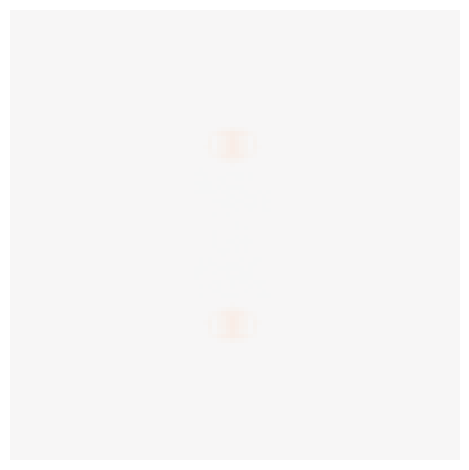

In [52]:
Utils.plot_rb(sol[905][:,:,6,1])

ArgumentError: ArgumentError: Image has max 1.128199e16,outside range

In [24]:
sol

retcode: Success
Interpolation: specialized 4th order "free" interpolation
t: 905-element Array{Float32,1}:
 0.0
 1.0f-6
 6.4444416f-6
 2.4450192f-5
 6.62239f-5
 0.00014112459
 0.00025240338
 0.00040083917
 0.00059357367
 0.000836073
 0.00113282
 0.001486989
 0.0019003447
 ⋮
 4.732325
 4.756958
 4.781688
 4.8065157
 4.8314404
 4.8564625
 4.881582
 4.906798
 4.932111
 4.9575205
 4.9830265
 5.0
u: 905-element Array{CuArray{Float32,4,Nothing},1}:
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

...

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0

## Try making struct to hold arrays eg f.x = x[:,:,:,:]
### first: BM how long that copy takes

In [ ]:
mutable struct testtt
    y::AbstractArray
end

In [ ]:
x= testtt(@view u0[:,:,1:2,:])

In [ ]:
yy = @view u0[:,:,1:2,:]
yyy = yy[:,:,:,:]

In [ ]:
@benchmark x.y = yyy

In [ ]:
x.y

In [ ]:
@benchmark begin
# x.y = @view u0[:,:,1:2,:]
x.y = yy[:,:,:,:]
end

In [ ]:

@benchmark begin
x.y = @view u0[:,:,1:2,:]
x.y = CuArray(x.y)
end

In [ ]:
x.y

In [ ]:
typeof(@view u0[:,:,1:2,:])

In [ ]:
typeof((@view u0[:,:,1:2,:])[:,:,:,:])

In [ ]:
xx = (@view u0[:,:,1:2,:])[:,:,:,:]
@. xx[:,:,1,:] = 1 

In [ ]:
@view u0[:,:,1:2,:][:,:,:,:]

In [ ]:
xx

In [ ]:
u0[:,:,1:2,:]

In [ ]:
mutable struct testta
    ya::AbstractArray
    yb::AbstractArray
end

In [ ]:
yaa = @view u0[:,:,1:2,:]
yba = CuArray(yaa)
x = testta(yaa, yba)

In [ ]:
x.ya

In [ ]:
x.yb

In [ ]:
@. x.yb[:,:,1,:] = 3f0

In [ ]:
x.yb

In [ ]:
x.ya

In [ ]:
@. x.ya = x.yb

In [ ]:
x.ya

In [ ]:
@benchmark begin
    x.ya = @view u0[:,:,1:2,:]
    x.yb = x.ya[:,:,:,:]
    @. x.yb = 4f0
    @. x.ya = x.yb
end

In [ ]:
@benchmark begin
    x.ya = @view u0[:,:,1:2,:]
    x.yb = CuArray(x.ya)
    @. x.yb = 4f0
    @. x.ya = x.yb
end

In [ ]:
@benchmark begin
    x.ya = @view u0[:,:,1:2,:]
    @. x.yb = CuArray(x.ya)
    @. x.yb = 4f0
    @. x.ya = x.yb
end

In [ ]:
@benchmark begin
    yana = @view u0[:,:,1:2,:]
    ybna = CuArray(yana)
    @. ybna = 4f0
    @. yana = ybna
end

In [ ]:
yanaa = @view u0[:,:,1:2,:]
@time  ybnc = CuArray(yanaa)

In [ ]:
x_lgn = cu(reshape(zeros(Float32, p.dim_i, p.dim_j), p.dim_i, p.dim_j, 1,1))
C = cu(reshape(zeros(Float32, p.dim_i, p.dim_j * p.K), p.dim_i, p.dim_j, p.K,1))
H_z = cu(reshape(zeros(Float32, p.dim_i, p.dim_j * p.K), p.dim_i, p.dim_j, p.K,1));
V_temp_1 = cu(reshape(zeros(Float32, p.dim_i, p.dim_j), p.dim_i, p.dim_j, 1,1));
V_temp_2 = cu(reshape(zeros(Float32, p.dim_i, p.dim_j), p.dim_i, p.dim_j, 1,1));
A_temp = cu(reshape(zeros(Float32, p.dim_i, p.dim_j * p.K), p.dim_i, p.dim_j, p.K,1));
B_temp = cu(reshape(zeros(Float32, p.dim_i, p.dim_j * p.K), p.dim_i, p.dim_j, p.K,1));

In [97]:
t= cu(reshape(zeros(Float32, p.dim_i, p.dim_j), p.dim_i, p.dim_j, 1,1))
t1= cu(reshape(zeros(Float32, p.dim_i, p.dim_j), p.dim_i, p.dim_j, 1,1))

100×100×1×1 CuArray{Float32,4,Nothing}:
[:, :, 1, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0

In [103]:
@benchmark ta = @view t[:, :, :,:]

BenchmarkTools.Trial: 
  memory estimate:  96 bytes
  allocs estimate:  1
  --------------
  minimum time:     3.971 μs (0.00% GC)
  median time:      4.023 μs (0.00% GC)
  mean time:        4.030 μs (0.00% GC)
  maximum time:     11.779 μs (0.00% GC)
  --------------
  samples:          10000
  evals/sample:     8

In [105]:
@benchmark t1 = @view t[:, :, :,:]

BenchmarkTools.Trial: 
  memory estimate:  176 bytes
  allocs estimate:  4
  --------------
  minimum time:     2.876 μs (0.00% GC)
  median time:      2.909 μs (0.00% GC)
  mean time:        2.918 μs (0.00% GC)
  maximum time:     14.290 μs (0.00% GC)
  --------------
  samples:          10000
  evals/sample:     9

In [106]:
t1

100×100×1×1 CuArray{Float32,4,CuArray{Float32,4,Nothing}}:
[:, :, 1, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0 

In [116]:
t = similar(u0)
tt = cu(reshape(zeros(Float32, p.dim_i, p.dim_j), p.dim_i, p.dim_j, 1,1))
ttt = cu(reshape(zeros(Float32, p.dim_i, p.dim_j), p.dim_i, p.dim_j, 1,1))

100×100×1×1 CuArray{Float32,4,Nothing}:
[:, :, 1, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0

In [109]:
@benchmark tp = @view t[:,:,1:1,:]

BenchmarkTools.Trial: 
  memory estimate:  176 bytes
  allocs estimate:  4
  --------------
  minimum time:     4.010 μs (0.00% GC)
  median time:      4.052 μs (0.00% GC)
  mean time:        4.073 μs (0.00% GC)
  maximum time:     9.525 μs (0.00% GC)
  --------------
  samples:          10000
  evals/sample:     8

In [113]:
@benchmark tt = @view t[:,:,1:1,:]

BenchmarkTools.Trial: 
  memory estimate:  176 bytes
  allocs estimate:  4
  --------------
  minimum time:     4.033 μs (0.00% GC)
  median time:      4.229 μs (0.00% GC)
  mean time:        4.237 μs (0.00% GC)
  maximum time:     9.280 μs (0.00% GC)
  --------------
  samples:          10000
  evals/sample:     8

In [119]:
tt = @view t[:,:,1:1,:];
typeof(tt)

SubArray{Float32,4,CuArray{Float32,4,Nothing},Tuple{Base.Slice{Base.OneTo{Int64}},Base.Slice{Base.OneTo{Int64}},UnitRange{Int64},Base.Slice{Base.OneTo{Int64}}},false}

In [132]:
@benchmark ttt = CuArray(tt)

BenchmarkTools.Trial: 
  memory estimate:  43.44 KiB
  allocs estimate:  116
  --------------
  minimum time:     120.878 μs (0.00% GC)
  median time:      124.929 μs (0.00% GC)
  mean time:        133.186 μs (2.90% GC)
  maximum time:     20.577 ms (73.18% GC)
  --------------
  samples:          10000
  evals/sample:     1

In [127]:
typeof(tt)

SubArray{Float32,4,CuArray{Float32,4,Nothing},Tuple{Base.Slice{Base.OneTo{Int64}},Base.Slice{Base.OneTo{Int64}},UnitRange{Int64},Base.Slice{Base.OneTo{Int64}}},false}

In [126]:
tttt = similar(tt);
typeof(tttt)

CuArray{Float32,4,Nothing}

In [128]:
ttttt = tt

100×100×1×1 view(::CuArray{Float32,4,Nothing}, :, :, 1:1, :) with eltype Float32:
[:, :, 1, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0

In [129]:
tt[1,1,1,1]

0.0f0

In [130]:
@benchmark ttt = tt[:,:,:,:]

BenchmarkTools.Trial: 
  memory estimate:  2.44 MiB
  allocs estimate:  60007
  --------------
  minimum time:     217.929 ms (0.00% GC)
  median time:      221.849 ms (0.00% GC)
  mean time:        221.752 ms (0.00% GC)
  maximum time:     223.426 ms (0.00% GC)
  --------------
  samples:          23
  evals/sample:     1

In [131]:
ttt = tt[:,:,:,:],
typeof(ttt)

(Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], CuArray{Float32,4,Nothing})

In [ ]:
@benchmark @. t = ff.x

In [149]:
du = u0
u = u0

100×100×12×1 CuArray{Float32,4,Nothing}:
[:, :, 1, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.

In [158]:
@time f(du, u, p, 1)
ff = f

  0.011061 seconds (7.72 k allocations: 1.238 MiB)


(::MEngProject.LaminartGPU.MyFunction{CuArray{Float32,4,Nothing}}) (generic function with 1 method)

In [168]:
# @time LaminartGPU.fun_x_lgn!(ff.x_lgn, ff.x, p)
# @time          LaminartGPU.fun_v_C!(ff.C, ff.v_p, ff.v_m, ff.V_temp_1, ff.V_temp_2, ff.A_temp, ff.B_temp, p)
# @time          LaminartGPU.fun_H_z!(ff.H_z, ff.z, p)
# @time          LaminartGPU.fun_dv!(ff.dv_p, ff.v_p, p.r, ff.x_lgn, p)
# @time        LaminartGPU.fun_dv!(ff.dv_m, ff.v_m, .-p.r, ff.x_lgn, p)
# @time    LaminartGPU.fun_dx_v1!(ff.dx, ff.x, ff.C, ff.z, p.x_V2, p)
# @time         LaminartGPU.fun_dy!(ff.dy, ff.y, ff.C, ff.x, ff.m, p)
# @time          LaminartGPU.fun_dm!(ff.dm, ff.m, ff.x, p)
# @time          LaminartGPU.fun_dz!(ff.dz, ff.z, ff.y, ff.H_z, ff.s, p)
@time      LaminartGPU.fun_ds!(ff.ds, ff.s, ff.H_z, p)

  0.000861 seconds (383 allocations: 15.938 KiB)


In [169]:
@time x_ = @view u[:, :, 1:p.K,:]

  0.000127 seconds (5 allocations: 208 bytes)


100×100×2×1 view(::CuArray{Float32,4,Nothing}, :, :, 1:2, :) with eltype Float32:
[:, :, 1, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0

In [170]:
ff.x = CuArray(x_)

100×100×2×1 CuArray{Float32,4,Nothing}:
[:, :, 1, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0

In [171]:
@time y_ = @view u[:, :, p.K+1:2*p.K,:]

  0.000137 seconds (5 allocations: 208 bytes)


100×100×2×1 view(::CuArray{Float32,4,Nothing}, :, :, 3:4, :) with eltype Float32:
[:, :, 1, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0

In [172]:
@time ff.y = CuArray(y_)

  0.000916 seconds (137 allocations: 82.953 KiB)


100×100×2×1 CuArray{Float32,4,Nothing}:
[:, :, 1, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0

In [173]:
x_ = @view u[:, :, 1:p.K,:]
        y_ = @view u[:, :, p.K+1:2*p.K,:]
        m_ = @view u[:, :, 2*p.K+1:3*p.K,:]
        z_ = @view u[:, :, 3*p.K+1:4*p.K,:]
        s_ = @view u[:, :, 4*p.K+1:5*p.K,:]

        v_p_ = @view u[:, :, 5*p.K+1:5*p.K+1,:]
        v_m_ = @view u[:, :, 5*p.K+2:5*p.K+2,:]

        dx_ = @view du[:, :, 1:p.K,:]
        dy_ = @view du[:, :, p.K+1:2*p.K,:]
        dm_ = @view du[:, :, 2*p.K+1:3*p.K,:]
        dz_ = @view du[:, :, 3*p.K+1:4*p.K,:]
        ds_ = @view du[:, :, 4*p.K+1:5*p.K,:]

        dv_p_ = @view du[:, :, 5*p.K+1:5*p.K+1,:]
        dv_m_ = @view du[:, :, 5*p.K+2:5*p.K+2,:]

100×100×1×1 view(::CuArray{Float32,4,Nothing}, :, :, 12:12, :) with eltype Float32:
[:, :, 1, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0    

In [175]:
@time begin
x_ = @view u[:, :, 1:p.K,:]
        y_ = @view u[:, :, p.K+1:2*p.K,:]
        m_ = @view u[:, :, 2*p.K+1:3*p.K,:]
        z_ = @view u[:, :, 3*p.K+1:4*p.K,:]
        s_ = @view u[:, :, 4*p.K+1:5*p.K,:]

        v_p_ = @view u[:, :, 5*p.K+1:5*p.K+1,:]
        v_m_ = @view u[:, :, 5*p.K+2:5*p.K+2,:]

        dx_ = @view du[:, :, 1:p.K,:]
        dy_ = @view du[:, :, p.K+1:2*p.K,:]
        dm_ = @view du[:, :, 2*p.K+1:3*p.K,:]
        dz_ = @view du[:, :, 3*p.K+1:4*p.K,:]
        ds_ = @view du[:, :, 4*p.K+1:5*p.K,:]

        dv_p_ = @view du[:, :, 5*p.K+1:5*p.K+1,:]
        dv_m_ = @view du[:, :, 5*p.K+2:5*p.K+2,:]
end

  0.000185 seconds (70 allocations: 2.844 KiB)


100×100×1×1 view(::CuArray{Float32,4,Nothing}, :, :, 12:12, :) with eltype Float32:
[:, :, 1, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0    

In [176]:
@time begin
ff.x = CuArray(x_)
        ff.y = CuArray(y_)
        ff.m =  CuArray(m_)
        ff.z =  CuArray(z_)
        ff.s = CuArray(s_)

        ff.v_p =  CuArray(v_p_)
        ff.v_m =  CuArray(v_m_)

        ff.dx =  CuArray(dx_)
        ff.dy =  CuArray(dy_)
        ff.dm =  CuArray(dm_)
        ff.dz =  CuArray(dz_)
        ff.ds =  CuArray(ds_)

        ff.dv_p =  CuArray(dv_p_)
        ff.dv_m =  CuArray(dv_m_)
end

  0.003369 seconds (1.81 k allocations: 1002.125 KiB)


100×100×1×1 CuArray{Float32,4,Nothing}:
[:, :, 1, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0

In [177]:
@time begin
ff.x = CuArray(x_)
        ff.y .= CuArray(y_)
        ff.m .=  CuArray(m_)
        ff.z .=  CuArray(z_)
        ff.s .= CuArray(s_)

        ff.v_p .=  CuArray(v_p_)
        ff.v_m .=  CuArray(v_m_)

        ff.dx .=  CuArray(dx_)
        ff.dy .=  CuArray(dy_)
        ff.dm .=  CuArray(dm_)
        ff.dz .=  CuArray(dz_)
        ff.ds .=  CuArray(ds_)

        ff.dv_p .=  CuArray(dv_p_)
        ff.dv_m .=  CuArray(dv_m_)
end

  0.004156 seconds (2.49 k allocations: 1.002 MiB)


100×100×1×1 CuArray{Float32,4,Nothing}:
[:, :, 1, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0

In [179]:
@time begin
  LaminartGPU.fun_x_lgn!(ff.x_lgn, ff.x, p)
        LaminartGPU.fun_v_C!(ff.C, ff.v_p, ff.v_m, ff.V_temp_1, ff.V_temp_2, ff.A_temp, ff.B_temp, p)
        LaminartGPU.fun_H_z!(ff.H_z, ff.z, p)

        LaminartGPU.fun_dv!(ff.dv_p, ff.v_p, p.r, ff.x_lgn, p)
        LaminartGPU.fun_dv!(ff.dv_m, ff.v_m, .-p.r, ff.x_lgn, p)
        LaminartGPU.fun_dx_v1!(ff.dx, ff.x, ff.C, ff.z, p.x_V2, p)
        LaminartGPU.fun_dy!(ff.dy, ff.y, ff.C, ff.x, ff.m, p)
        LaminartGPU.fun_dm!(ff.dm, ff.m, ff.x, p)
        LaminartGPU.fun_dz!(ff.dz, ff.z, ff.y, ff.H_z, ff.s, p)
        LaminartGPU.fun_ds!(ff.ds, ff.s, ff.H_z, p)
end

  0.037345 seconds (6.04 k allocations: 293.156 KiB)


In [180]:
@time begin
@. x_ = ff.x
        @. y_ =ff.y
        @. m_ =ff.m
        @. z_ = ff.z
        @. s_ = ff.s

        @. v_p_ = ff.v_p
        @. v_m_ = ff.v_m

        @. dx_ = ff.dx
        @. dy_ = ff.dy
        @. dm_ = ff.dm
        @. dz_ = ff.dz
        @. ds_ = ff.ds

		@. dv_p_ = ff.dv_p
        @. dv_m_ = ff.dv_m
end

  0.001749 seconds (1.32 k allocations: 61.453 KiB)


100×100×1×1 view(::CuArray{Float32,4,Nothing}, :, :, 12:12, :) with eltype Float32:
[:, :, 1, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0    

In [181]:
@time begin
        ff.x .= CuArray(x_)
        ff.y .= CuArray(y_)
        ff.m .=  CuArray(m_)
        ff.z .=  CuArray(z_)
        ff.s .= CuArray(s_)

        ff.v_p .=  CuArray(v_p_)
        ff.v_m .=  CuArray(v_m_)

        ff.dx .=  CuArray(dx_)
        ff.dy .=  CuArray(dy_)
        ff.dm .=  CuArray(dm_)
        ff.dz .=  CuArray(dz_)
        ff.ds .=  CuArray(ds_)

        ff.dv_p .=  CuArray(dv_p_)
        ff.dv_m .=  CuArray(dv_m_)
end

  0.003795 seconds (2.54 k allocations: 1.004 MiB)


100×100×1×1 CuArray{Float32,4,Nothing}:
[:, :, 1, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0

In [182]:
@time begin
ff.x = CuArray(x_)
       @. ff.y = CuArray(y_)
        ff.m =  CuArray(m_)
        ff.z =  CuArray(z_)
        ff.s = CuArray(s_)

        ff.v_p .=  CuArray(v_p_)
        ff.v_m .=  CuArray(v_m_)

        ff.dx .=  CuArray(dx_)
        ff.dy .=  CuArray(dy_)
        ff.dm .=  CuArray(dm_)
        ff.dz .=  CuArray(dz_)
        ff.ds .=  CuArray(ds_)

        ff.dv_p .=  CuArray(dv_p_)
        ff.dv_m .=  CuArray(dv_m_)
end

GPUCompiler.InvalidIRError: InvalidIRError: compiling kernel broadcast(CUDA.CuKernelContext, CuDeviceArray{Float32,4,CUDA.AS.Global}, Base.Broadcast.Broadcasted{Nothing,NTuple{4,Base.OneTo{Int64}},CUDA.var"#869#870"{CuArray},Tuple{Base.Broadcast.Extruded{SubArray{Float32,4,CuDeviceArray{Float32,4,CUDA.AS.Global},Tuple{Base.Slice{Base.OneTo{Int64}},Base.Slice{Base.OneTo{Int64}},UnitRange{Int64},Base.Slice{Base.OneTo{Int64}}},false},NTuple{4,Bool},NTuple{4,Int64}}}}) resulted in invalid LLVM IR
Reason: unsupported dynamic function invocation (call to CuArray)
Stacktrace:
 [1] #869 at /mnt/storage_1/users/cullinanen/.julia/packages/CUDA/h38pe/src/broadcast.jl:21
 [2] _broadcast_getindex_evalf at broadcast.jl:631
 [3] _broadcast_getindex at broadcast.jl:604
 [4] getindex at broadcast.jl:564
 [5] #20 at /mnt/storage_1/users/cullinanen/.julia/packages/GPUArrays/4W5rW/src/host/broadcast.jl:59

In [187]:
 @time ff.y = CuArray(y_)

  0.000546 seconds (130 allocations: 82.750 KiB)


100×100×2×1 CuArray{Float32,4,Nothing}:
[:, :, 1, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0

In [186]:
 @time ff.y .= y_

  0.000507 seconds (105 allocations: 4.922 KiB)


100×100×2×1 CuArray{Float32,4,Nothing}:
[:, :, 1, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0

In [188]:
@time begin
@. ff.x = x_
@. ff.y = y_
@. ff.m =  m_
@. ff.z =  z_
@. ff.s = s_

@. ff.v_p =  v_p_
@. ff.v_m =  v_m_

@. ff.dx = dx_
@. ff.dy =  dy_
@. ff.dm =  dm_
@. ff.dz =  dz_
@. ff.ds =  ds_

@. ff.dv_p =  dv_p_
@. ff.dv_m =  dv_m_
end

  0.002197 seconds (1.37 k allocations: 66.062 KiB)


100×100×1×1 CuArray{Float32,4,Nothing}:
[:, :, 1, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0

In [189]:
ff.x

100×100×2×1 CuArray{Float32,4,Nothing}:
[:, :, 1, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0

In [190]:
x_

100×100×2×1 view(::CuArray{Float32,4,Nothing}, :, :, 1:2, :) with eltype Float32:
[:, :, 1, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0

In [24]:
@. f.x = @view u0[:, :, 1:p.K,:]
@. f.x = f.x =11f0

100×100×2×1 CuArray{Float32,4,Nothing}:
[:, :, 1, 1] =
 11.0  11.0  11.0  11.0  11.0  11.0  …  11.0  11.0  11.0  11.0  11.0  11.0
 11.0  11.0  11.0  11.0  11.0  11.0     11.0  11.0  11.0  11.0  11.0  11.0
 11.0  11.0  11.0  11.0  11.0  11.0     11.0  11.0  11.0  11.0  11.0  11.0
 11.0  11.0  11.0  11.0  11.0  11.0     11.0  11.0  11.0  11.0  11.0  11.0
 11.0  11.0  11.0  11.0  11.0  11.0     11.0  11.0  11.0  11.0  11.0  11.0
 11.0  11.0  11.0  11.0  11.0  11.0  …  11.0  11.0  11.0  11.0  11.0  11.0
 11.0  11.0  11.0  11.0  11.0  11.0     11.0  11.0  11.0  11.0  11.0  11.0
 11.0  11.0  11.0  11.0  11.0  11.0     11.0  11.0  11.0  11.0  11.0  11.0
 11.0  11.0  11.0  11.0  11.0  11.0     11.0  11.0  11.0  11.0  11.0  11.0
 11.0  11.0  11.0  11.0  11.0  11.0     11.0  11.0  11.0  11.0  11.0  11.0
 11.0  11.0  11.0  11.0  11.0  11.0  …  11.0  11.0  11.0  11.0  11.0  11.0
 11.0  11.0  11.0  11.0  11.0  11.0     11.0  11.0  11.0  11.0  11.0  11.0
 11.0  11.0  11.0  11.0  11.0  11.0     11.0 

In [25]:
u0[:, :, 1:p.K,:]

100×100×2×1 CuArray{Float32,4,Nothing}:
[:, :, 1, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0

In [26]:
@time @. f.x = @view u0[:, :, 1:p.K,:]

  0.000457 seconds (103 allocations: 4.922 KiB)


100×100×2×1 CuArray{Float32,4,Nothing}:
[:, :, 1, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0

In [27]:
@time begin
    x_ = @view u0[:, :, 1:p.K,:]
    @. f.x = x_
    @. x_ = f.x
end

  0.031826 seconds (1.66 k allocations: 85.125 KiB)


100×100×2×1 view(::CuArray{Float32,4,Nothing}, :, :, 1:2, :) with eltype Float32:
[:, :, 1, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0

In [ ]:
@time begin
    x_ = @view u0[:, :, 1:p.K,:]
    @. f.x = x_
    @. x_ = f.x
end

In [28]:
@. @view u0[:, :, 1:p.K,:] = f.x

LoadError: ArgumentError: Invalid use of @view macro: argument must be a reference expression A[...].

In [30]:
@time begin
    @. f.x = @view u0[:, :, 1:p.K,:]
    @. u0[:, :, 1:p.K,:] = f.x
end

  0.000708 seconds (205 allocations: 9.578 KiB)


100×100×2×1 view(::CuArray{Float32,4,Nothing}, :, :, 1:2, :) with eltype Float32:
[:, :, 1, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0

In [36]:
f_1 = LaminartGPU.MyFunction_1(
    similar(arr1),
    similar(arr1),
    similar(arr1),
    similar(arr1),
    similar(arr1),
    similar(arr2),
    similar(arr2),
    similar(arr1),
    similar(arr1),
    similar(arr1),
    similar(arr1),
    similar(arr1),
    similar(arr2),
    similar(arr2),
    x_lgn, C, H_z, V_temp_1, V_temp_2, A_temp, B_temp);

In [37]:
prob_1 = ODEProblem(f_1, u0, tspan, p);

In [38]:
sol_1 = solve(prob_1)

retcode: Success
Interpolation: specialized 4th order "free" interpolation
t: 905-element Array{Float32,1}:
 0.0
 1.0f-6
 6.4444416f-6
 2.4450192f-5
 6.62239f-5
 0.00014112459
 0.00025240338
 0.00040083917
 0.00059357367
 0.000836073
 0.00113282
 0.001486989
 0.0019003447
 ⋮
 4.732325
 4.756958
 4.781688
 4.8065157
 4.8314404
 4.8564625
 4.881582
 4.906798
 4.932111
 4.9575205
 4.9830265
 5.0
u: 905-element Array{CuArray{Float32,4,Nothing},1}:
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

...

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0

In [ ]:
@benchmark sol_1 = solve(prob_1)